In [10]:
import pandas as pd
import csv


#1 Carga y limpieza de datos


In [11]:
#Archivo a trabajar
file = 'EEG_eyes_classification.csv'
file_filtered = 'filtered_file.csv'
"""
Informacion del archivo:
-Class: b'1' = 0; b'2' = 1 y valores atipicos
Manejar valores nulos, identificar cada una de las columnas y corregir lo que se encuentre.
HINT: calcular el porcentaje de valores por columna es de gran ayuda, sin tener miedo a eliminar lo que no sirve.
"""

def calcular_porcentaje_vacios(fila):
    # Calcula el número de valores vacíos en la fila
    num_vacios = sum(1 for valor in fila if not valor.strip())
    # Calcula el porcentaje de valores vacíos
    porcentaje_vacios = (num_vacios / len(fila))
    return porcentaje_vacios

#Se filtran las columnas con mas de un dato faltante
with open(file, 'r') as csvfile, open(file_filtered, 'w', newline='') as newcsv:
    reader = csv.reader(csvfile, delimiter=',')
    writer = csv.writer(newcsv)
    for row in reader:
        porcentaje_vacio = calcular_porcentaje_vacios(row)

        if porcentaje_vacio < 2/16:#Antes 2/16
            if row[-1] == "b'1'":
                row[-1] = 0
            elif row[-1] == "b'2'":
                row[-1] = 1
            elif row[-1] == "Open":
                row[-1] = 0
            if row[-1] == "Close" or row[-1] == "Closed":
                row[-1] = 1
            writer.writerow(row)

#2 Balanceo de datos


In [12]:
df = pd.read_csv('filtered_file.csv')

count_0 = (df['Class'] == 0).sum()
count_1 = (df['Class'] == 1).sum()

diff = abs(count_0-count_1)

if count_0>count_1:
    df = df.drop(df[df['Class'] == 0].sample(n=diff).index)

else:
    df = df.drop(df[df['Class'] == 1].sample(n=diff).index)

count_0 = (df['Class'] == 0).sum()
count_1 = (df['Class'] == 1).sum()

df.to_csv('filtered_file.csv', index=False)

#3 Estandarización de datos

In [13]:
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('filtered_file.csv')

#Se seleccionan todas las columnas menos la ultima
columnas_a_estandarizar = df.columns[:-1]

scaler = StandardScaler()
#Se hace el estandarizado
df[columnas_a_estandarizar] = scaler.fit_transform(df[columnas_a_estandarizar])

df.to_csv('filtered_file.csv', index=False)

#4 Separación del data set:
60% Train
20% Test
20% Validation

In [14]:
from sklearn.model_selection import train_test_split

df = pd.read_csv('filtered_file.csv')

X = df.drop(columns = ['Class'])
y = df['Class']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)

X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

#Se tiene X_train, y_train para TRAIN, X_test, y_test para el Testeo, y X_val, y_val para la Validacion

#5 Entrenamiento


In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

#Entrenamiento con hiperparametros default

#Random Forest
rf_default = RandomForestClassifier(random_state=42)
rf_default.fit(X_train, y_train)

#Desicion tree
dt_default = DecisionTreeClassifier(random_state=42)
dt_default.fit(X_train, y_train)

#Logistic regresion
lr_default = LogisticRegression(random_state=42)
lr_default.fit(X_train, y_train)

#Realizar la prediccion para el conjunto de Testeo
rf_pred_default = rf_default.predict(X_test)
dt_pred_default = dt_default.predict(X_test)
lr_pred_default = lr_default.predict(X_test)

#Calcular la precision de los modelos con hiperparametros default
rf_acc_default = accuracy_score(y_test, rf_pred_default)
dt_acc_default = accuracy_score(y_test, dt_pred_default)
lr_acc_default = accuracy_score(y_test, lr_pred_default)

# Calcular matriz de confusión
conf_matrix_test = confusion_matrix(y_test, rf_pred_default)
print("Matriz de Confusión con el conjunto de prueba de Random Forest:")
print(conf_matrix_test)
conf_matrix_test = confusion_matrix(y_test, dt_pred_default)
print("Matriz de Confusión con el conjunto de prueba de Decision Tree:")
print(conf_matrix_test)
conf_matrix_test = confusion_matrix(y_test, lr_pred_default)
print("Matriz de Confusión con el conjunto de prueba de Regresión logística:")
print(conf_matrix_test)

print("------------------------------------------")

print("Precisión con hiperparámetros predeterminados:")
print("Random Forest:", rf_acc_default)
print("Decision Tree:", dt_acc_default)
print("Regresión Logística:", lr_acc_default)

# Definir los rangos de hiperparámetros para la búsqueda
rf_param_grid = {'n_estimators': [10, 50, 100],
                 'max_depth': [None, 10, 20]}

dt_param_grid = {'max_depth': [None, 10, 20],
                 'min_samples_split': [2, 5, 10]}

lr_param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

# Realizar la búsqueda de hiperparámetros utilizando RandomizedSearchCV o GridSearchCV
rf_random_search = RandomizedSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, n_iter=9, cv=5, random_state=42)
dt_grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), dt_param_grid, cv=5)
lr_grid_search = GridSearchCV(LogisticRegression(random_state=42), lr_param_grid, cv=5)


# Entrenar los modelos con los mejores hiperparámetros encontrados
rf_random_search.fit(X_train, y_train)
dt_grid_search.fit(X_train, y_train)
lr_grid_search.fit(X_train, y_train)


# Obtener los mejores modelos
rf_best = rf_random_search.best_estimator_
dt_best = dt_grid_search.best_estimator_
lr_best = lr_grid_search.best_estimator_

# Realizar predicciones en el conjunto de prueba utilizando los mejores modelos
rf_pred_best = rf_best.predict(X_test)
dt_pred_best = dt_best.predict(X_test)
lr_pred_best = lr_best.predict(X_test)

# Calcular la precisión de los modelos con los mejores hiperparámetros
rf_acc_best = accuracy_score(y_test, rf_pred_best)
dt_acc_best = accuracy_score(y_test, dt_pred_best)
lr_acc_best = accuracy_score(y_test, lr_pred_best)

print("------------------------------------------")
print("Precisión con hiperparámetros optimizados:")
print("Random Forest:", rf_acc_best)
print("Decision Tree:", dt_acc_best)
print("Regresión Logística:", lr_acc_best)

ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

#7 Elija un modelo y explique por qué es el mejor en base a los resultados obtenidos y muestre las variables más importantes.

Según los datos obtenidos anteriormente, podemos decir con seguridad de que el mejor modelo será el de Random Forest, debido a que según la precisión fue el que tuvo mejor desempeño y según la matriz de confusión obtuvo la menor cantidad de datos erroneos.

A continuación se mostrarán las variables más relevantes en función con su importancia para las predicciones del modelo

In [ ]:
# Obtener la importancia de las características del modelo de Random Forest
feature_importance = rf_best.feature_importances_

# Crear un DataFrame para visualizar las características y su importancia
feature_importance_df = pd.DataFrame({'Etiqueta': X.columns, 'Importancia': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importancia', ascending=False)

# Mostrar las características más importantes
print("Características más importantes:")
print(feature_importance_df.head(10))

Características más importantes:
   Etiqueta  Importancia
6        V7     0.122009
5        V6     0.094308
12      V13     0.083035
1        V2     0.073223
11      V12     0.064972
2        V3     0.063939
8        V9     0.061234
7        V8     0.059116
13      V14     0.058122
4        V5     0.057317


#7 Grafico datos predichos por Random Forest v/s datos reales

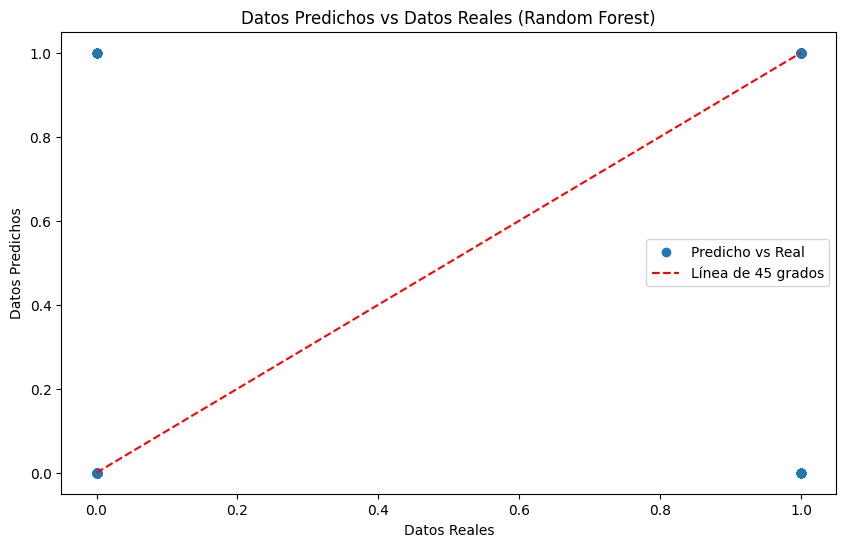

In [ ]:
import matplotlib.pyplot as plt

# Graficar los datos predichos vs los datos reales
plt.figure(figsize=(10, 6))
plt.scatter(y_test, rf_pred_best, label='Predicho vs Real')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Línea de 45 grados')
plt.xlabel('Datos Reales')
plt.ylabel('Datos Predichos')
plt.title('Datos Predichos vs Datos Reales (Random Forest)')
plt.legend()
plt.show()